In [1]:
import csv
import cv2
import sys
import pickle
import random
import numpy as np

import os
import json

import matplotlib.pyplot as plt

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Flatten, ELU
from keras.regularizers import l2

from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
print("module imported")

module imported


In [3]:
#ch, row, col = 3, 160, 320
channels, rows, columns = 3, 66, 200  # camera format

In [4]:
#Fetch data from pickle file
with open('data/driving_data.p', mode='rb') as f:
    driving_data = pickle.load(f)

training_images = driving_data['training_images']
training_angles = driving_data['training_angles']
validation_images = driving_data['validation_images']
validation_angles = driving_data['validation_angles']

#print("max:", max(labels))
#print("min:", min(labels))

#shuffle a dataset
#images, labels = shuffle(center_images, labels)

# split train & valid data
X_train, X_validation, y_train, y_validation = training_images, validation_images, training_angles, validation_angles

print(len(X_train))
print(len(X_validation))

11860
50


In [5]:
#custom rows and columns to fit Nvidia model
custom_rows, custom_cols = 66, 200

def flip_image(image, angle):
    if random.randint(0, 1):
        return cv2.flip(image, 1), -angle
    else:
        return image, angle
    
def rotate_image(image, angle):
    rows,cols,channel = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), random.uniform(-5, 5), 1)
    return cv2.warpAffine(image,M,(cols,rows)), angle

def brightness_image(image, steering):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = hsv[:,:,2] * random.uniform(0.3, 1.2)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR), steering

def cut_image(img):
    rows,cols,channel = img.shape
    top = int(.4 * rows)
    botton = int(.85 * rows)
    border = int(.05 * cols)
    return img[top:botton, border:cols-border, :]

#Crop image as required
#http://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python
def crop_image(image, y1, y2, x1, x2):
    return image[y1:y2, x1:x2]

#translate image and compensate for the translation on the steering angle
def translate_image(image, steering, horz_range=30, vert_range=5):
    rows, cols, chs = image.shape
    tx = np.random.randint(-horz_range, horz_range+1)
    ty = np.random.randint(-vert_range, vert_range+1)
    steering = steering + tx * 0.004 # multiply by steering angle units per pixel
    tr_M = np.float32([[1,0,tx], [0,1,ty]])
    image = cv2.warpAffine(image, tr_M, (cols,rows), borderMode=1)
    return image, steering

def augment_image(image, angle):
    
    #Flip
    #image, angle = flip_image(np.copy(image),angle)
    
    #Crop
    #image = crop_image(image, 20, 140, 50, 270)
    image = cut_image(image)
    
    #Rotate image
    #image, angle = rotate_image(image,angle)
    
    #Translate. This will help with sharp turnings
    if random.randint(0, 1):
        image, steering = translate_image(np.copy(image), angle)
    
    #Brightness
    #image, angle = brightness_image(np.copy(image),angle)

    return image, angle

def get_image(center_images, left_images, right_images, labels, index, image_offset=0.25):
    
    camera = np.random.choice(['center', 'left', 'right'])
    
    if camera == 'center':
        image, steering = plt.imread("data/"+center_images[index]), float(labels[index])
    elif camera == 'left':
        image, steering = plt.imread("data/"+left_images[index]), float(labels[index])+image_offset
    elif camera == 'right':
        image, steering = plt.imread("data/"+right_images[index]), float(labels[index])-image_offset
    
    #image and steering
    #image, steering = plt.imread("data/"+car_images[index]), float(labels[index])
    
    #Augment image 
    image, angle = augment_image(image, steering)
    
    #Resize image
    image = cv2.resize(image, (custom_cols, custom_rows))
    image = np.reshape(image, (1, custom_rows, custom_cols, channels))
    return image, steering

def get_image1(training_images, training_angles, index):
    
    image, steering = plt.imread("data/"+training_images[index]), float(training_angles[index])
    
    #Augment image 
    image, angle = augment_image(image, steering)
     
    #Resize image
    image = cv2.resize(image, (custom_cols, custom_rows))
    image = np.reshape(image, (1, custom_rows, custom_cols, channels))
    return image, steering

def get_flipped_image(image, angle):
    image = plt.imread("data/"+image)
    image, angle = flip_image(np.copy(image),angle)
    #Resize image
    image = cv2.resize(image, (custom_cols, custom_rows))
    image = np.reshape(image, (1, custom_rows, custom_cols, channels))
    return image, angle

#Custom generator for model training
def my_generator(center_images, left_images, right_images, labels, batch_size):
    batch_train = np.zeros((batch_size, rows, columns, 3))
    batch_angle = np.zeros(batch_size)
    while True:
        for index in range(batch_size):
            image, angle = get_image(center_images, left_images, right_images, labels, index)
            batch_train[index], batch_angle[index] = image, angle
        yield batch_train, batch_angle
        
def my_generator1(training_images, training_angles, batch_size=64):
    batch_train = np.zeros((batch_size, rows, columns, 3))
    batch_angle = np.zeros(batch_size)
    while True:
        training_images, training_angles = shuffle(training_images, training_angles)
        current_index = 0
        print("training images len:", len(training_images))
        for index in range(len(training_images)):
            image, angle = get_image1(training_images, training_angles, index)
            print("current index:", current_index)
            batch_train[current_index], batch_angle[current_index] = image, angle
            #Flip
            current_index = current_index + 1
            print("current index:", current_index)
            image, angle = get_flipped_image(training_images[index], training_angles[index])
            batch_train[current_index], batch_angle[current_index] = image, angle
            current_index = current_index + 1
            if current_index>= batch_size:
                yield batch_train, batch_angle

def my_generator2(training_images, training_angles, batch_size=64):
    batch_size=64
    X = np.zeros((batch_size, rows, columns, 3))
    Y = np.zeros(batch_size)
    while True:
        training_images, training_angles = shuffle(training_images, training_angles) 
        for index, angle in enumerate(training_angles):
            image, angle = get_image1(training_images, training_angles, index)
            np.append(X,image)
            np.append(Y,angle)
            
            image, angle = get_flipped_image(training_images[index], training_angles[index])
            np.append(X,image)
            np.append(Y,angle)

            if len(X)>=batch_size:
                X, Y = shuffle(X, Y)
                #print("Batch _ size : ", batch_size)
                #print("X size:", len(X))
                #print("Y sie:", len(Y))
                yield X, Y # (image, steering angle)
                X = np.zeros((batch_size, rows, columns, 3))
                Y = np.zeros(batch_size)

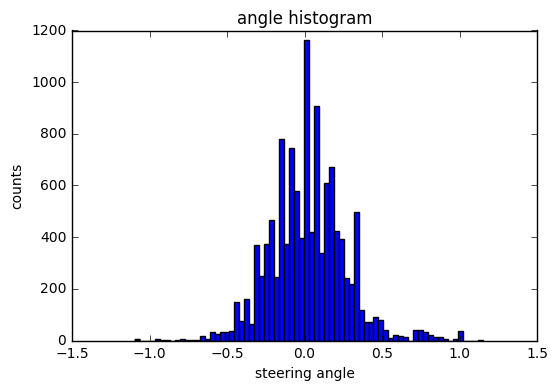

In [6]:
# histogram of labels count

plt.hist(training_angles, bins=70)
plt.title('angle histogram')
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()

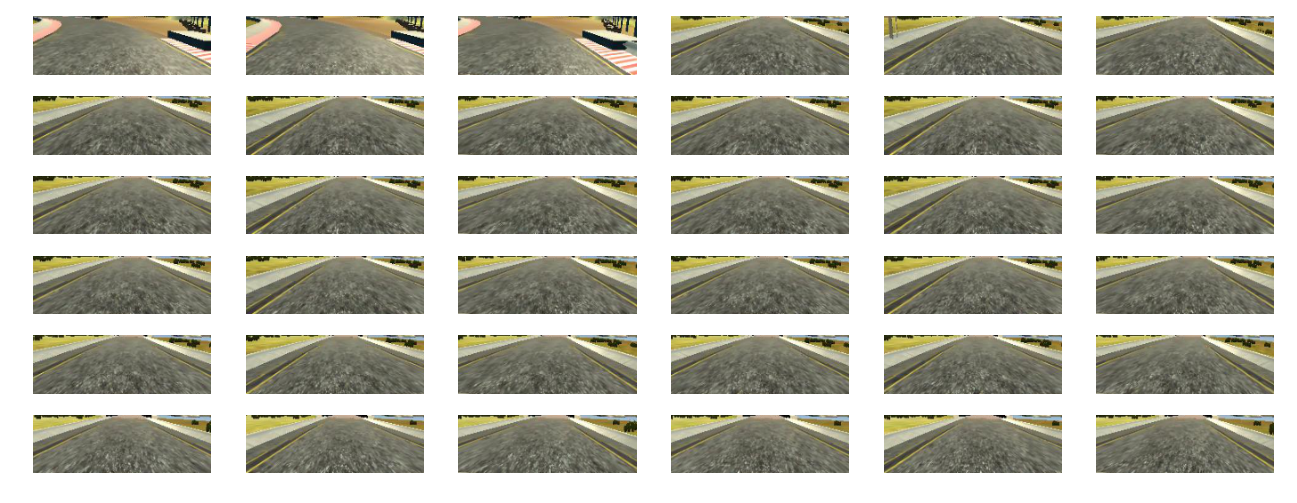

In [7]:
#Randomly print few images
plt.figure(figsize=(16,6))
for i in range(36):
    #random_index = np.random.randint(0,len(center_images))
    #image,angle = get_image(center_images, left_images, right_images, labels, i)
    image,angle = get_image1(training_images, training_angles, i)
    #image,angle = get_image1(center_images, labels, i)
    plt.subplot(6,6,i+1)
    plt.imshow(image.squeeze(), cmap="gray");
    plt.axis('off')
plt.show()

In [ ]:
def commaai_model(time_len=1):

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
    model.add(Convolution2D(16, 8, 8, input_shape=(3,160,320), subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    return model

def nvidia_model(time_len=1):
    ch, row, col = 3, 66, 200  # camera format
    INIT='glorot_uniform' # 'he_normal', glorot_uniform
    keep_prob = 0.2
    reg_val = 0.01
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)) )
    # W_regularizer=l2(reg_val)
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Flatten())

    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(10))
    model.add(ELU())
    
    model.add(Dense(1))

    #model.compile(optimizer="adam", loss="mse") # , metrics=['accuracy']
    
    return model

def create_model():
    # create the base pre-trained model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=[66, 200, 3])

    x = base_model.output
    x = Flatten()(x)

    # and a regression layer to predict steering angle
    x = Dense(1000, activation='relu', name='fc1', W_regularizer=l2(0.0001))(x)
    #x = Dropout(0.5)(x)
    x = Dense(250, activation='relu', name='fc2', W_regularizer=l2(0.0001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)

    model = Model(input=base_model.input, output=predictions)
    # train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    
    #model.compile(loss='mean_squared_error', optimizer='adam')
    #model = load_model("model.h5")
    return model

In [ ]:
batch_size = 32
EPOCHS = 14

model = nvidia_model()

#print model summary
#model.summary()

# Compile model using Adam optimizer
# and loss computed by mean squared error
model.compile(loss='mean_squared_error',
              optimizer=Adam(0.0001),
              metrics=['accuracy'], 
              validation_data=(X_validation, y_validation), 
              verbose=0)

my_generator = my_generator2(training_images, training_angles, batch_size)

# Model training
history = model.fit_generator(
    my_generator,
    samples_per_epoch=batch_size*(int((len(2*training_images)/batch_size))-1), # of training samples
    nb_epoch=EPOCHS,
    verbose=1
)

print("model training complete")

/Users/khaleel.pasha/anaconda/envs/selfDrivingCarCourseEnvironment/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1917: UserWarning: Expected no kwargs, you passed 2
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/14
23680/23680 [==============================] - 257s - loss: 1.5966 - acc: 0.9873   
Epoch 2/14
23680/23680 [==============================] - 273s - loss: 0.8038 - acc: 1.0000   
Epoch 3/14
 5440/23680 [=====>........................] - ETA: 211s - loss: 0.4653 - acc: 1.0000

In [ ]:
#Save the model
model_json = 'model.json'
model_weights = 'model.h5'

json_string = model.to_json()
try:
    os.remove(model_json)
    os.remove(model_weights)
except OSError:
    pass

with open(model_json, 'w') as jfile:
    json.dump(json_string, jfile)
model.save(model_weights)

print("model saved")